In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io

matrix= scipy.io.loadmat("/home/ponnana/PhD/Yinling_copy/data_new.mat")

m = matrix["data_new"][:,0]
v =  matrix["data_new"][:,1]
s = matrix["data_new"][:,2]
k = matrix["data_new"][:,3]

tExp = [0.01058, 0.03158, 0.05258, 0.07358, 0.09458, 0.1156, 0.1366, 0.1576, 0.1786, 0.1996, 0.2206,
          0.2300, 0.2756, 0.3316, 0.3876, 0.4436, 0.4496, 0.5556, 0.6116, 0.6676, 0.7206, 0.7796, 0.8356,
          0.8916, 0.9476, 1.004, 1.060, 1.105, 1.124, 1.153, 1.182, 1.211, 1.240, 1.269, 1.298, 1.327,
          1.356, 1.385, 1.414, 1.443, 1.472, 1.501, 1.530, 1.559, 1.588, 1.617, 1.646, 1.670]

tExp = np.array(tExp)


t1,t2 = 0.24,1.1
xExp = np.concatenate((matrix["data_new"], tExp.reshape(-1,1)), axis=1)
xExp = xExp.astype(float)


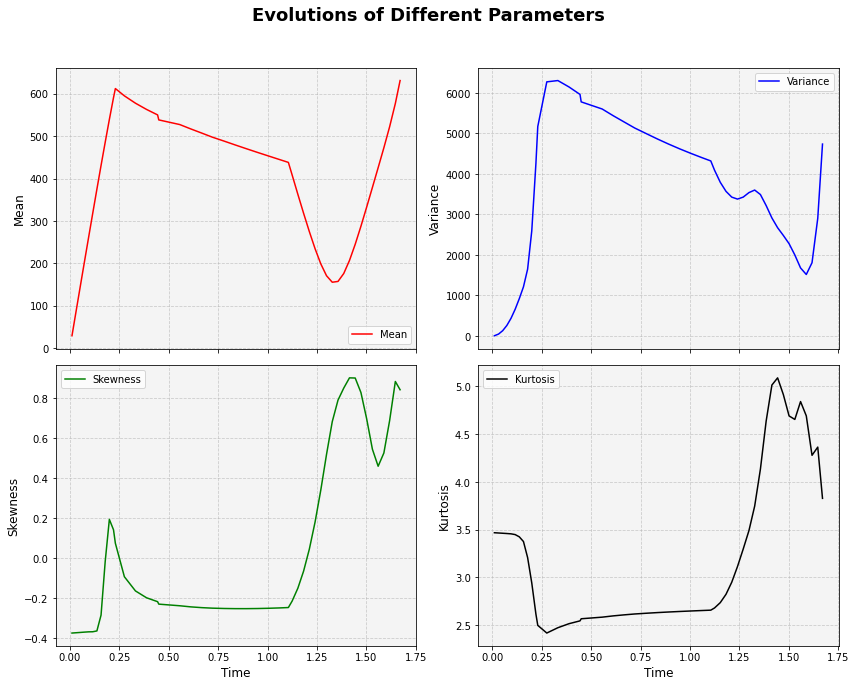

In [2]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(12, 10), sharex=True)

# Plot Mean
axs[0, 0].plot(tExp, xExp[:, 0], 'r', label='Mean')
axs[0, 0].set_ylabel("Mean", fontsize=12)
axs[0, 0].legend()
axs[0, 0].set_facecolor('#F4F4F4')
axs[0, 0].grid(True, linestyle='--', alpha=0.6)

# Plot Variance
axs[0, 1].plot(tExp, xExp[:, 1], 'b', label='Variance')
axs[0, 1].set_ylabel("Variance", fontsize=12)
axs[0, 1].legend()
axs[0, 1].set_facecolor('#F4F4F4')
axs[0, 1].grid(True, linestyle='--', alpha=0.6)

# Plot Skewness
axs[1, 0].plot(tExp, xExp[:, 2], 'g', label='Skewness')
axs[1, 0].set_xlabel("Time", fontsize=12)
axs[1, 0].set_ylabel("Skewness", fontsize=12)
axs[1, 0].legend()
axs[1, 0].set_facecolor('#F4F4F4')
axs[1, 0].grid(True, linestyle='--', alpha=0.6)

# Plot Kurtosis
axs[1, 1].plot(tExp, xExp[:, 3], 'k', label='Kurtosis')
axs[1, 1].set_xlabel("Time", fontsize=12)
axs[1, 1].set_ylabel("Kurtosis", fontsize=12)
axs[1, 1].legend()
axs[1, 1].set_facecolor('#F4F4F4')
axs[1, 1].grid(True, linestyle='--', alpha=0.6)

# Customize the overall appearance
fig.suptitle("Evolutions of Different Parameters", fontsize=18, fontweight='bold')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the layout to prevent clipping

# Show the plot
plt.show()


In [3]:
maxValues = np.max(xExp,axis=0)
maxValues[-1]=1
xExpNormal = xExp/maxValues
truncIndex = np.where(xExpNormal[:,1]>=0.0999)
xExpTruncNormal = xExpNormal[truncIndex,:]
xExpTruncNormal = np.squeeze(xExpTruncNormal)
tExpTrunc = xExpTruncNormal[:,-1]

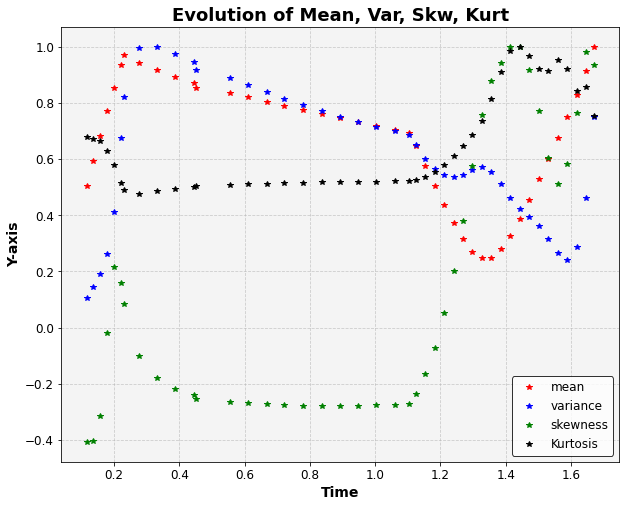

In [4]:
fig, ax = plt.subplots(figsize=(10, 8))
plt.plot(tExpTrunc,xExpTruncNormal[:,0], 'r*',label='mean')

plt.plot(tExpTrunc,xExpTruncNormal[:,1], 'b*',label='variance')

plt.plot(tExpTrunc,xExpTruncNormal[:,2], 'g*',label='skewness')

plt.plot(tExpTrunc,xExpTruncNormal[:,3], 'k*',label='Kurtosis')

ax.legend()
ax.grid(True, linestyle='--', alpha=0.6)

# Customize fonts and sizes
ax.set_title("Evolution of Mean, Var, Skw, Kurt", fontsize=18, fontweight='bold')
ax.set_xlabel("Time", fontsize=14, fontweight='bold')
ax.set_ylabel("Y-axis", fontsize=14, fontweight='bold')

# Increase tick label font size
ax.tick_params(axis='both', labelsize=12)

# Customize the appearance of the legend
legend = ax.legend(loc='lower right', fontsize=12)
legend.get_frame().set_edgecolor('black')
ax.set_facecolor('#F4F4F4')

# Show the plot
plt.show()


In [5]:
tBreak1 = 0.23
tBreak2 = 1.105
xExpTruncNormal1 = xExpTruncNormal[0:np.where(tExpTrunc==tBreak1)[0][0]+1,:]

xExpTruncNormal2 = xExpTruncNormal[np.where(tExpTrunc==tBreak1)[0][0]:np.where(tExpTrunc==tBreak2)[0][0]+1,:]
# Train the nn from the previous point.

xExpTruncNormal3 = xExpTruncNormal[np.where(tExpTrunc==tBreak2)[0][0]:,:]
# Train the nn from the previous point.

tExpTrunc1= xExpTruncNormal1[:,-1]
tExpTrunc2= xExpTruncNormal2[:,-1]
tExpTrunc3= xExpTruncNormal3[:,-1]

In [6]:
import os
import argparse
import time
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

torch.manual_seed(1000)
np.random.seed(1000)

parser = argparse.ArgumentParser('ODE demo')
parser.add_argument('--method', type=str, choices=['dopri5', 'adams'], default='dopri5')
parser.add_argument('--data_size', type=int, default=1000)
parser.add_argument('--batch_time', type=int, default=15)
parser.add_argument('--batch_size', type=int, default=100)
parser.add_argument('--niters', type=int, default=2000)
parser.add_argument('--test_freq', type=int, default=20)
parser.add_argument('--viz', action='store_true')
parser.add_argument('--gpu', type=int, default=0)
parser.add_argument('--adjoint', action='store_true')

# Parse arguments when running in Jupyter notebook
args = parser.parse_args(args=[])

if args.adjoint:
    from torchdiffeq import odeint_adjoint as odeint
else:
    from torchdiffeq import odeint

device = torch.device('cuda:' + str(args.gpu) if torch.cuda.is_available() else 'cpu')

## Part1 (0-0.24 sec)

In [7]:
from scipy.interpolate import interp1d
tTrain3 = np.linspace(np.min(tExpTrunc3), np.max(tExpTrunc3), args.data_size)
quad_interp_p3 = interp1d(tExpTrunc3, xExpTruncNormal3, kind='quadratic', axis=0)
xTrain3 = quad_interp_p3(tTrain3) 

In [8]:
clear true_y 

In [9]:
## Setting up the true system
true_y0 = torch.from_numpy(xTrain3[0,:]).to(device).to(dtype=torch.float)
t = torch.from_numpy(tTrain3).to(dtype=torch.float)
true_y = torch.from_numpy(xTrain3).unsqueeze(1).to(dtype=torch.float)

In [31]:
## Get mini-batch data from the training dataset 
def get_batch():
    s = torch.from_numpy(np.random.choice(np.arange(args.data_size - args.batch_time, dtype=np.int64), args.batch_size, replace=False))
    batch_y0 = true_y[s]  # (M, D)
    batch_t = torch.stack([t[i:i+args.batch_time] for i in s]) # (T)
    batch_y = torch.stack([true_y[s + i] for i in range(args.batch_time)], dim=1)  # (T, M, D)
    batch_y=batch_y.permute(2,0,1,3)
    return batch_y0.to(device), batch_t.to(device), batch_y.to(device)

## Utility functions for visualization of results 
def makedirs(dirname):
    if not os.path.exists(dirname):
        os.makedirs(dirname)

if args.viz:
    makedirs('png')
    import matplotlib.pyplot as plt
    fig = plt.figure(figsize=(8, 4), facecolor='white')
    ax_traj = fig.add_subplot(121, frameon=False)
    ax_phase = fig.add_subplot(122, frameon=False)
    plt.show(block=False)

def visualize(true_y, pred_y, odefunc, itr):

    if args.viz:

        ax_traj.cla()
        ax_traj.set_title('Trajectories')
        ax_traj.set_xlabel('t')
        ax_traj.set_ylabel('x,y')
        ax_traj.plot(t.cpu().numpy(), true_y.cpu().numpy()[:, 0, 0], t.cpu().numpy(), true_y.cpu().numpy()[:, 0, 1], 'g-', label = 'True System')
        ax_traj.plot(t.cpu().numpy(), pred_y.cpu().numpy()[:, 0, 0], '--', t.cpu().numpy(), pred_y.cpu().numpy()[:, 0, 1], 'b--', label = 'Neural ODE')
        ax_traj.set_xlim(t.cpu().min(), t.cpu().max())
        ax_traj.set_ylim(-2, 2)
        ax_traj.legend()

        ax_phase.cla()
        ax_phase.set_title('Phase Portrait')
        ax_phase.set_xlabel('x')
        ax_phase.set_ylabel('y')
        ax_phase.plot(true_y.cpu().numpy()[:, 0, 0], true_y.cpu().numpy()[:, 0, 1], 'g-')
        ax_phase.plot(pred_y.cpu().numpy()[:, 0, 0], pred_y.cpu().numpy()[:, 0, 1], 'b--')
        ax_phase.set_xlim(-2, 2)
        ax_phase.set_ylim(-2, 2)

        fig.tight_layout()
        plt.savefig('png/{:03d}'.format(itr))
        plt.draw()
        plt.pause(0.001)


## Construct a neural network to approximate the dynamics of an ODE
class ODEFunc(nn.Module):

    def __init__(self):
        super(ODEFunc, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(5, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 4)
        )

        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, y):
        return self.net(y)
    
func = ODEFunc().to(device)
    
def combined_system(t, y):
    dt_dt = 1
    dt_dt = torch.tensor([dt_dt])
    output_tensor = func(t, y)  # Using ODEFunc to get dx2/dt, dx3/dt, dx4/dt
    return torch.cat([output_tensor,dt_dt], dim=0)

In [32]:
ii = 0
## Setting up the optimizer
optimizer = optim.RMSprop(func.parameters(), lr=0.0001)

for itr in range(1, args.niters + 1):
#for itr in range(1, 20):
        ## Using mini-batch data to update the neural network coefficients
        optimizer.zero_grad()
        batch_y0, batch_t, batch_y = get_batch()
        solutions = []
        temp1 = 0
        for ic in batch_y0:
            sol = odeint(combined_system, ic[0], batch_t[temp1])
            solutions.append(sol)
            temp1 = temp1+1
        pred_y_toCaclLoss= torch.stack(solutions).unsqueeze(0)
        #pred_y = pred_y.permute(2, 1, 0, 3)
        loss = torch.mean(torch.abs(pred_y_toCaclLoss - batch_y))
        loss.backward()
        optimizer.step()

        if itr % args.test_freq == 0 or itr == 1:
            with torch.no_grad():
                pred_y = odeint(combined_system, true_y0, t)
                pred_y = pred_y.unsqueeze(1)  
                loss = torch.mean(torch.abs(pred_y - true_y))
                print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))
                visualize(true_y, pred_y, func, ii)
                ii += 1

Iter 0001 | Total Loss 0.291578
Iter 0020 | Total Loss 0.255435
Iter 0040 | Total Loss 0.234634
Iter 0060 | Total Loss 0.218290
Iter 0080 | Total Loss 0.205294
Iter 0100 | Total Loss 0.196661
Iter 0120 | Total Loss 0.194154
Iter 0140 | Total Loss 0.188356
Iter 0160 | Total Loss 0.182951
Iter 0180 | Total Loss 0.179995
Iter 0200 | Total Loss 0.178994
Iter 0220 | Total Loss 0.181476
Iter 0240 | Total Loss 0.183181
Iter 0260 | Total Loss 0.184573
Iter 0280 | Total Loss 0.183754
Iter 0300 | Total Loss 0.181509
Iter 0320 | Total Loss 0.181789
Iter 0340 | Total Loss 0.180649
Iter 0360 | Total Loss 0.176220
Iter 0380 | Total Loss 0.176654
Iter 0400 | Total Loss 0.176970
Iter 0420 | Total Loss 0.168411
Iter 0440 | Total Loss 0.162972
Iter 0460 | Total Loss 0.159637
Iter 0480 | Total Loss 0.150502
Iter 0500 | Total Loss 0.146906
Iter 0520 | Total Loss 0.144944
Iter 0540 | Total Loss 0.138768
Iter 0560 | Total Loss 0.128645
Iter 0580 | Total Loss 0.124190
Iter 0600 | Total Loss 0.117135
Iter 062

In [18]:
optimizer = optim.RMSprop(func.parameters(), lr=0.00001)
for itr in range(2000, 3000):
#for itr in range(1, 20):
        ## Using mini-batch data to update the neural network coefficients
        optimizer.zero_grad()
        batch_y0, batch_t, batch_y = get_batch()
        solutions = []
        temp1 = 0
        for ic in batch_y0:
            sol = odeint(combined_system, ic[0], batch_t[temp1])
            solutions.append(sol)
            temp1 = temp1+1
        pred_y_toCaclLoss= torch.stack(solutions).unsqueeze(0)
        #pred_y = pred_y.permute(2, 1, 0, 3)
        loss = torch.mean(torch.abs(pred_y_toCaclLoss - batch_y))
        loss.backward()
        optimizer.step()

        if itr % args.test_freq == 0 or itr == 1:
            with torch.no_grad():
                pred_y = odeint(combined_system, true_y0, t)
                pred_y = pred_y.unsqueeze(1)  
                loss = torch.mean(torch.abs(pred_y - true_y))
                print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))
                visualize(true_y, pred_y, func, ii)
                ii += 1

Iter 2000 | Total Loss 0.066993
Iter 2020 | Total Loss 0.062998
Iter 2040 | Total Loss 0.063500
Iter 2060 | Total Loss 0.063894
Iter 2080 | Total Loss 0.063436
Iter 2100 | Total Loss 0.063068
Iter 2120 | Total Loss 0.063080
Iter 2140 | Total Loss 0.063029
Iter 2160 | Total Loss 0.063415
Iter 2180 | Total Loss 0.064743
Iter 2200 | Total Loss 0.064013
Iter 2220 | Total Loss 0.063792
Iter 2240 | Total Loss 0.063826
Iter 2260 | Total Loss 0.064195
Iter 2280 | Total Loss 0.064172
Iter 2300 | Total Loss 0.064522
Iter 2320 | Total Loss 0.064282
Iter 2340 | Total Loss 0.064145
Iter 2360 | Total Loss 0.064777
Iter 2380 | Total Loss 0.063930
Iter 2400 | Total Loss 0.063469
Iter 2420 | Total Loss 0.063736
Iter 2440 | Total Loss 0.064584
Iter 2460 | Total Loss 0.064217
Iter 2480 | Total Loss 0.064069
Iter 2500 | Total Loss 0.063073
Iter 2520 | Total Loss 0.063105
Iter 2540 | Total Loss 0.063461
Iter 2560 | Total Loss 0.063693
Iter 2580 | Total Loss 0.063069
Iter 2600 | Total Loss 0.063058


KeyboardInterrupt: 

In [21]:
optimizer = optim.RMSprop(func.parameters(), lr=0.000001)
for itr in range(2600, 3000):
#for itr in range(1, 20):
        ## Using mini-batch data to update the neural network coefficients
        optimizer.zero_grad()
        batch_y0, batch_t, batch_y = get_batch()
        solutions = []
        temp1 = 0
        for ic in batch_y0:
            sol = odeint(combined_system, ic[0], batch_t[temp1])
            solutions.append(sol)
            temp1 = temp1+1
        pred_y_toCaclLoss= torch.stack(solutions).unsqueeze(0)
        #pred_y = pred_y.permute(2, 1, 0, 3)
        loss = torch.mean(torch.abs(pred_y_toCaclLoss - batch_y))
        loss.backward()
        optimizer.step()

        if itr % args.test_freq == 0 or itr == 1:
            with torch.no_grad():
                pred_y = odeint(combined_system, true_y0, t)
                pred_y = pred_y.unsqueeze(1)  
                loss = torch.mean(torch.abs(pred_y - true_y))
                print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))
                visualize(true_y, pred_y, func, ii)
                ii += 1

Iter 2600 | Total Loss 0.062993
Iter 2620 | Total Loss 0.063019
Iter 2640 | Total Loss 0.063095
Iter 2660 | Total Loss 0.063096
Iter 2680 | Total Loss 0.062916
Iter 2700 | Total Loss 0.063046
Iter 2720 | Total Loss 0.063048
Iter 2740 | Total Loss 0.063094
Iter 2760 | Total Loss 0.063128
Iter 2780 | Total Loss 0.063128
Iter 2800 | Total Loss 0.063126
Iter 2820 | Total Loss 0.063099
Iter 2840 | Total Loss 0.063138
Iter 2860 | Total Loss 0.063214
Iter 2880 | Total Loss 0.063264
Iter 2900 | Total Loss 0.063284
Iter 2920 | Total Loss 0.063315
Iter 2940 | Total Loss 0.063344
Iter 2960 | Total Loss 0.063304
Iter 2980 | Total Loss 0.063273


/tmp/ipykernel_29302/1420193857.py:30: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


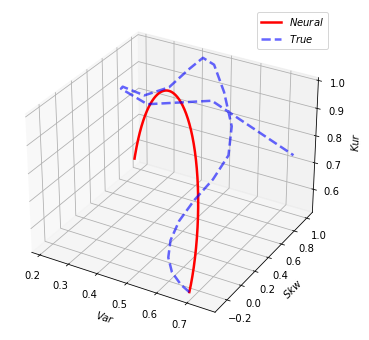

In [33]:
# Assuming ODEFunc is the name of your neural network class
model = func


model.eval()


# Initial state
y0 = true_y0
#y0= torch.tensor([ 0,  0.5, 0, 0])

# Time point for prediction
t_value = t
with torch.no_grad():
    predicted_states = odeint(combined_system,y0 , t).to(device)
    
predicted_states=predicted_states.numpy()

plot_kws = dict(linewidth=2)

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection="3d")

#ax.plot(x_train[:, 1], x_train[:, 2], x_train[:, 3], "k*", label="$given$")

ax.plot(predicted_states[:, 1], predicted_states[:, 2], predicted_states[:, 3], "r", label="$Neural$", linewidth=2.5,alpha =1)
ax.plot(xExpTruncNormal3[:, 1], xExpTruncNormal3[:, 2],xExpTruncNormal3[:, 3], "b--", label="$True$", linewidth=2.5,alpha =0.6)
ax.set(xlabel="$Var$", ylabel="$Skw$", zlabel="$Kur$")
ax.legend()
fig.show()

#z_true = true_y[:,0,2].numpy()

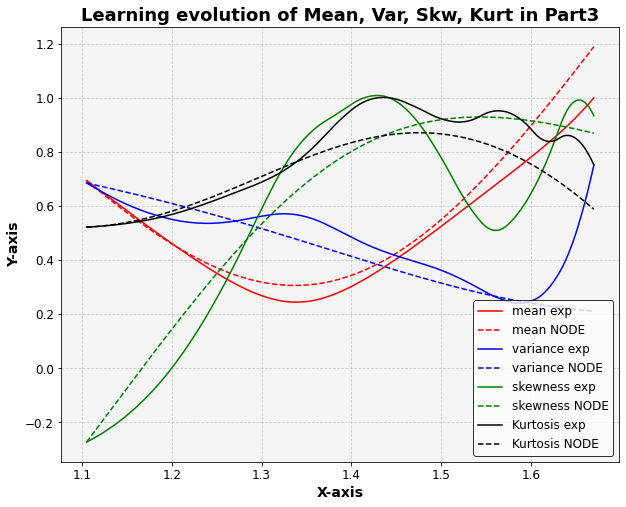

In [34]:
fig, ax = plt.subplots(figsize=(10, 8))
plt.plot(tTrain3,xTrain3[:,0], 'r',label='mean exp')
plt.plot(tTrain3,predicted_states[:,0], 'r--',label='mean NODE')

plt.plot(tTrain3,xTrain3[:,1], 'b',label='variance exp')
plt.plot(tTrain3,predicted_states[:,1], 'b--',label='variance NODE')

plt.plot(tTrain3,xTrain3[:,2], 'g',label='skewness exp')
plt.plot(tTrain3,predicted_states[:,2], 'g--',label='skewness NODE')

plt.plot(tTrain3,xTrain3[:,3], 'k',label='Kurtosis exp')
plt.plot(tTrain3,predicted_states[:,3], 'k--',label='Kurtosis NODE')

ax.legend()
ax.grid(True, linestyle='--', alpha=0.6)

# Customize fonts and sizes
ax.set_title("Learning evolution of Mean, Var, Skw, Kurt in Part3", fontsize=18, fontweight='bold')
ax.set_xlabel("X-axis", fontsize=14, fontweight='bold')
ax.set_ylabel("Y-axis", fontsize=14, fontweight='bold')

# Increase tick label font size
ax.tick_params(axis='both', labelsize=12)

# Customize the appearance of the legend
legend = ax.legend(loc='lower right', fontsize=12)
legend.get_frame().set_edgecolor('black')
ax.set_facecolor('#F4F4F4')

plt.savefig('learningPart3.pdf', bbox_inches='tight')

# Show the plot
plt.show()


In [14]:
torch.save(func, 'part3.pth')

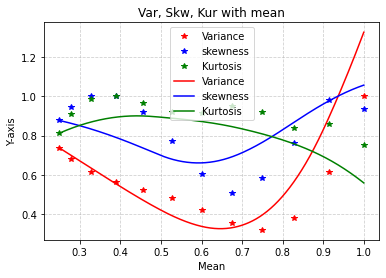

In [52]:
# Create a plot with different labels for each column

plt.plot(temp_m_t_p3, temp_x_t_m_p3[:, 1], 'r*',label='Variance')
plt.plot(temp_m_t_p3, temp_x_t_m_p3[:, 2], 'b*',label='skewness')
plt.plot(temp_m_t_p3, temp_x_t_m_p3[:, 3], 'g*',label='Kurtosis')

plt.plot(t, predicted_states[:, 1], 'r',label='Variance')
plt.plot(t, predicted_states[:, 2], 'b',label='skewness')
plt.plot(t, predicted_states[:, 3], 'g',label='Kurtosis')

# Add labels and title
plt.xlabel('Mean')
plt.ylabel('Y-axis')
plt.title('Var, Skw, Kur with mean')

# Add a legend
plt.legend()

# Add grid
plt.grid(True, linestyle='--', alpha=0.6)

# Display the plot
plt.show()

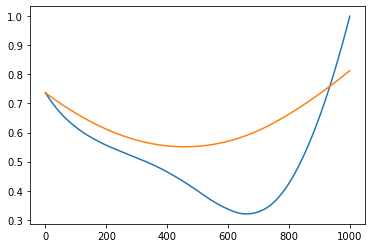

In [38]:
#plt.plot(np.log(x_t_m_p3[:,1]))
plt.plot(x_t_m_p3[:,1])
plt.plot(predicted_states[:,1])

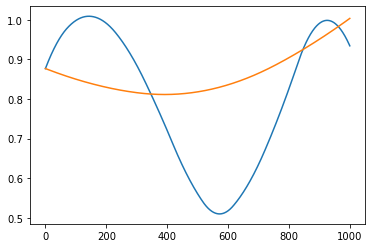

In [39]:
plt.plot(x_t_m_p3[:,2])
plt.plot(predicted_states[:,2])

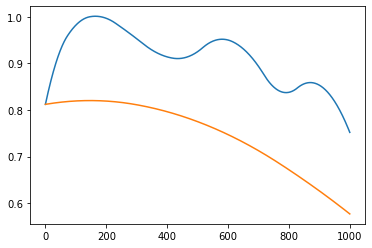

In [40]:
plt.plot(x_t_m_p3[:,3])
plt.plot(predicted_states[:,3])

In [26]:
loaded_func1 = torch.load('part1.pth')
loaded_func2 = torch.load('part2.pth')
loaded_func3 = torch.load('part3.pth')

In [27]:
true_y0 = torch.from_numpy(xTrain1[0,:]).to(device).to(dtype=torch.float)

NameError: name 'xTrain1' is not defined